# Processing a (fake) globular cluster with the DM Science Pipelines

Start with some imports.  You won't have `tqdm` (a very nice progress bar package) until you install it yourself, which you should do now: open a terminal and run `pip install tqdm --user`.  You may have to restart kernel for this notebook afterwards.

In [1]:
import numpy as np
from tqdm import tqdm_notebook
from lsst.daf.persistence import Butler
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
from lsst.afw.image import Exposure, Image, PARENT

TODO: update the repo root after data is moved to the right places and made read-only

In [2]:
butler = Butler("/scratch/__datasets/hsc/with-globular")

In [3]:
dataId = {"tract": 9813, "patch":"4,4"}

In [4]:
coadds = {b: butler.get("deepCoadd_calexp", dataId, filter="HSC-{}".format(b.upper())) for b in "griz"}

This is an coadd of HSC observations of the COSMOS field, with a simulated globular cluster added in (using scaled fluxes and positions from a real globular cluster, added to the image using our own PSF models).  This is something the DM Pipelines aren't very good at processing (at least right now), and that makes it a good example for using DM code to build specialized higher-level algorithms.  (Note that this still won't be as as hard as processing a real globular cluster, as this is a pretty simplified case - none of the simulated stars are saturated, and we subtracted the background before adding them).

We'll start by just looking at the images, as 3-color composites.  We'll use astropy to build those as a nice way to demonstrate how to get NumPy arrays from LSST `Exposure` objects like those in the `coadds` dict (LSST also has code to make 3-color composites using the same algorithm, and in fact the Astropy implementation is based on ours).

In [5]:
from astropy.visualization import make_lupton_rgb
from matplotlib import pyplot
%matplotlib inline

In [6]:
def showRGB(exps, bands="gri"):
    # Extract the image component of each Exposure with .image property, and use .array to get a NumPy array view.
    rgb = make_lupton_rgb(image_r=exps[bands[2]].image.array, image_g=exps[bands[1]].image.array, image_b=exps[bands[0]].image.array, stretch=1, Q=10)
    pyplot.figure(figsize=(20, 15))
    # Convert from integer bounding box (coordinates at centers of pixels) to floating-point bounding box (coordinates at edges of pixels)
    # to get the kind of bounds imshow's extent argument expects
    bbox = Box2D(exps[bands[0]].getBBox())
    pyplot.imshow(rgb, interpolation='nearest', origin='lower', extent=(bbox.getMinX(), bbox.getMaxX(), bbox.getMinY(), bbox.getMaxY()))

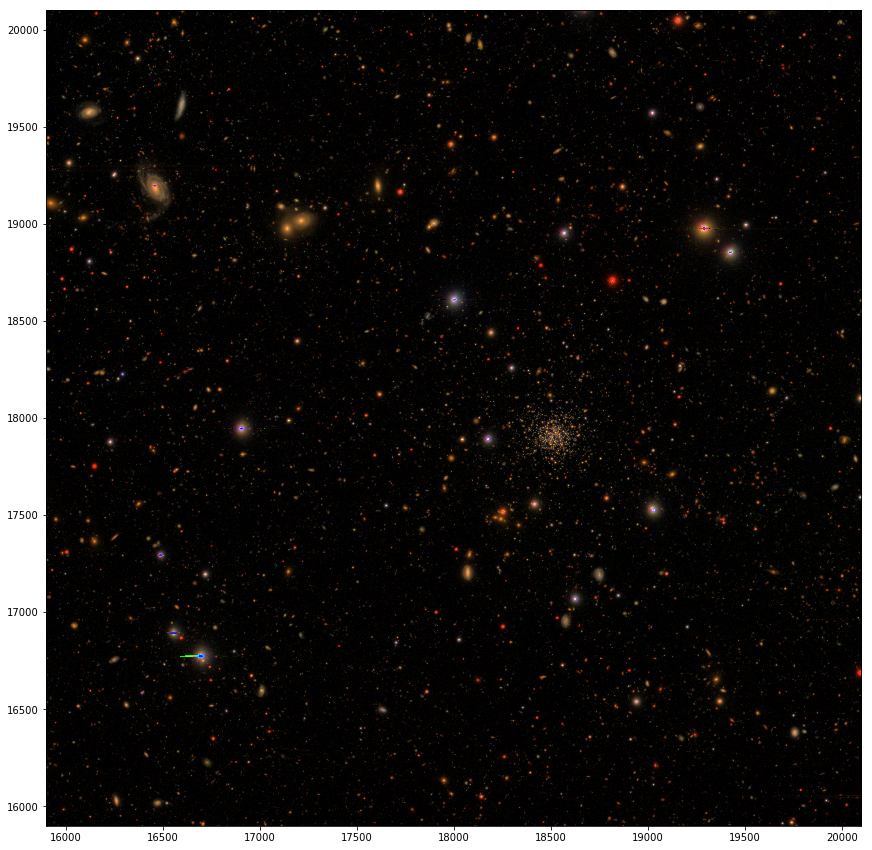

In [7]:
showRGB(coadds, "gri")

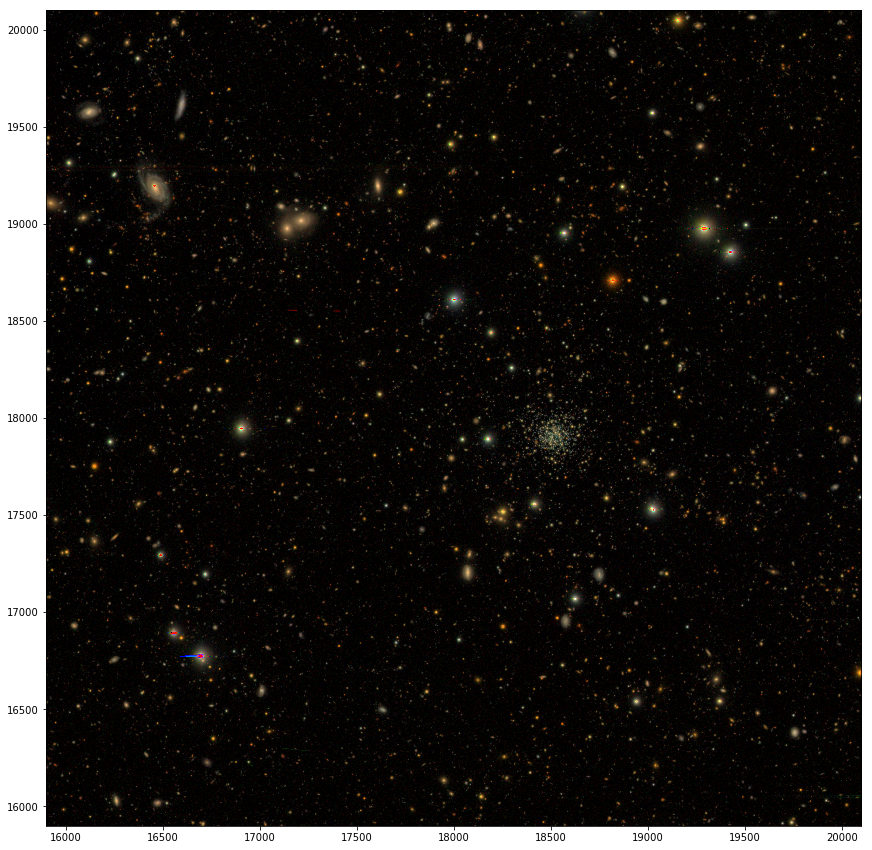

In [8]:
showRGB(coadds, "riz")

Those images are a full "patch", which is our usual unit of processing for coadds - it's about the same size as a single LSST sensor (exactly the same in pixels, smaller in terms of area because these use HSC's smaller pixel scale).  That's a bit unweildy for this tutorial, where we don't have much patience for slow algorithms, so we'll reload our dict with sub-images centered on the cluster.  Note that we can load the sub-images directly with the `butler`, by appending `_sub` and passing a `bbox` argument.

In [10]:
coadds = {b: butler.get("deepCoadd_calexp_sub", dataId, filter="HSC-{}".format(b.upper()),
                        bbox=Box2I(minimum=Point2I(18325, 17725), dimensions=Extent2I(400, 350))) for b in "griz"}

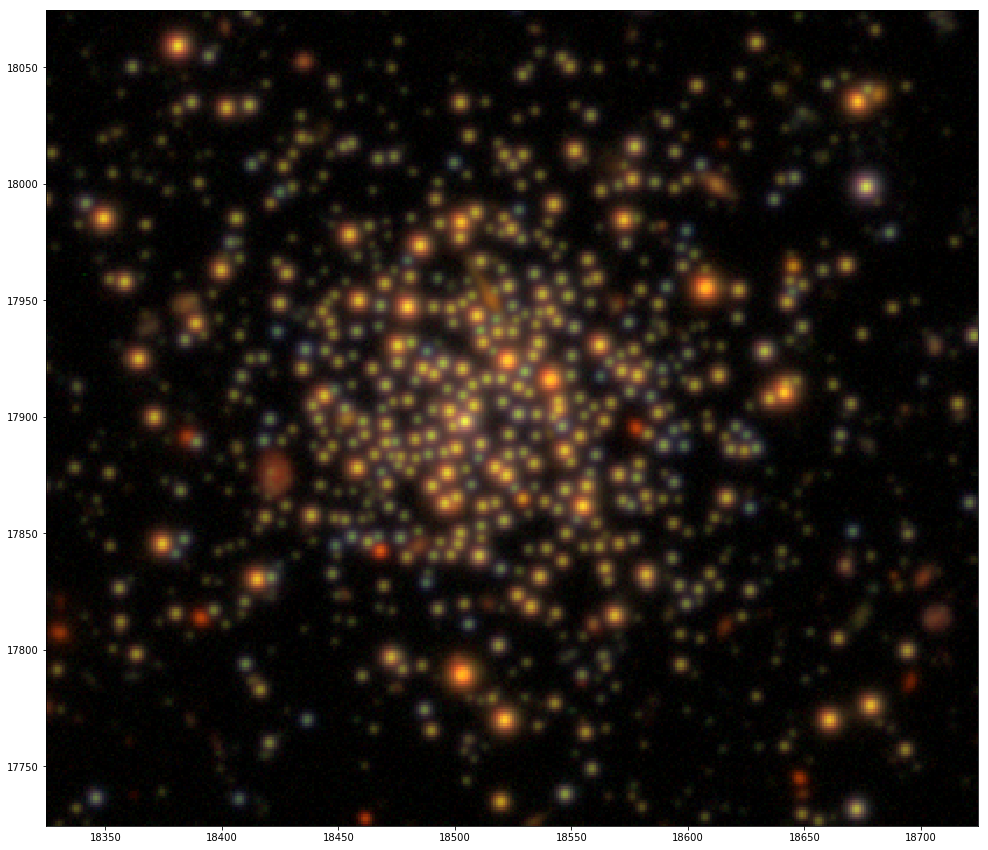

In [11]:
showRGB(coadds, "gri")

Now we'll try the regular LSST processing tasks (with a simpler configuration than we usually run them on coadds, just to avoid being distracted by complexity or spending time on algorithms we don't care about here).

Note that we construct all Tasks before actually running any of them.  If you don't do this, you can end up with inconsistent configuration and schemas.  (TODO: expand on this).

In [12]:
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.afw.table import SourceCatalog

In [13]:
schema = SourceCatalog.Table.makeMinimalSchema()
detectionTask = SourceDetectionTask(schema=schema)
deblendTask = SourceDeblendTask(schema=schema)
measureConfig = SingleFrameMeasurementTask.ConfigClass()
measureConfig.plugins.names = ["base_SdssCentroid", "base_PsfFlux"]
measureConfig.slots.apFlux = None
measureConfig.slots.instFlux = None
measureConfig.slots.shape = None
measureConfig.slots.modelFlux = None
measureConfig.slots.calibFlux = None
measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)

Here's where we actually start running the Tasks:
(TODO: say something about what each Task does, show how the catalog is modified at every step)

In [14]:
table = SourceCatalog.Table.make(schema)
detectionResult = detectionTask.run(table, coadds['r'])
catalog = detectionResult.sources

In [15]:
deblendTask.run(coadds['r'], catalog)

/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/meas_deblender/15.0-4-gf6f1c6c+1/python/lsst/meas/deblender/plugins.py:669: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X1, r1, rank1, s1 = np.linalg.lstsq(Aw[:, :NT1], bw)
/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/meas_deblender/15.0-4-gf6f1c6c+1/python/lsst/meas/deblender/plugins.py:671: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X2, r2, rank2, s2 = np.linalg.lstsq(Aw, bw)
/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4

Note: DM-14669 will squash these warnings.  Should try to get that in before the next weekly is released.

In [16]:
measureTask.run(catalog, coadds['r'])

Now we'll look at the results using Firefly.  First some setup:

In [17]:
from lsst.afw.display import setDefaultBackend, getDisplay
from IPython.display import IFrame
import os
setDefaultBackend("firefly")
channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsp-demo.lsst.codes'

Execute the next cell if you want to use Firefly from within a notebook cell.  You can also use a different browser tab/window (a link will appear a few cells below).  There's nothing stopping you from using both, but it can be a little confusing trying to track what is shared between the two displays and what is not

In [18]:
IFrame('{}/firefly/slate.html?__wsch={}'.format(server, channel), 1024, 768)

In either case, we now need to create a display object associate with one frame in the Firefly window (that will also give us that link):

In [19]:
display = getDisplay(frame=1, name=channel)

We can now display an `Exposure` object:

After doing that, take some time play around with the GUI.  There are a lot of transparent mask overlays that can make it hard to see the image, but the layers window gives you very detailed control over them.

In [20]:
display.mtv(coadds["r"])

The function below overplots the sources we detected on the image.  Firefly itself has much more sophisticated ways of interacting them with catalogs, but we haven't gotten them integrated fully with our Python libraries yet.

In [22]:
def showCatalog(disp, cat, ctype='orange', sym='+'):
    with disp.Buffering():
        for record in catalog:
            if record["deblend_nChild"] == 0:
                disp.dot(sym, record.getX()-0.5, record.getY()-0.5, size=5, ctype=ctype)

In [23]:
showCatalog(display, catalog)

To see how well that measurement worked, we'll use the PSF model and the measure PSF fluxes to subtract all of the objects.  Some of those objects are actually well-resolved galaxies, so we don't expect them to subtract well, but we'll just ignore that for now and focus our attention on the stars.

TODO: walk through the implementation of this function

In [24]:
def subtractStars(data, cat, fluxes=None):
    assert (cat["deblend_nChild"] == 0).all()
    psf = data.getPsf()
    model = Exposure(data.getBBox(), dtype=np.float32)
    model.setWcs(data.getWcs())
    model.setPsf(psf)
    if fluxes is None:
        fluxes = cat.getPsfFlux()
    for flux, record in zip(fluxes, tqdm_notebook(cat)):
        psfImage = data.getPsf().computeImage(record.getCentroid())
        psfBBox = psfImage.getBBox()
        if not data.getBBox().contains(psfBBox):
            psfBBox.clip(data.getBBox())
            psfImage = psfImage[psfBBox, PARENT]
        model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    residuals = data.clone()
    residuals.image -= model.image
    return model, residuals

In [25]:
deblended = catalog[catalog["deblend_nChild"] == 0].copy(deep=True)
model, residuals = subtractStars(coadds['r'], deblended)

Make two more display frames to show the residuals (frame 2) and model (frame 3).

Use the "WCS Match" and single-frame view to blink between them and the original image.

In [26]:
display2 = getDisplay(frame=2, name=channel)
display2.mtv(residuals)

In [27]:
display3 = getDisplay(frame=3, name=channel)
display3.mtv(model)

The isolated objects seem to be subtracted well, and *some* of the deblended ones are too.  But others really didn't subtract well at all; the deblender must be mangling those.  (TODO: look at some HeavyFootprints?)

But from the overplotted positions, it looks like the centroids aren't too bad, even if the fluxes frequently are.

For better photometry, let's just fit a fixed-position PSF model to every object.

Once again, this will go poorly for galaxies, and we'll ignore that.  We could also imagine adding terms to fit small offsets in the positions, or using sparse matrices to make this scale better.  But this works well enough for this tutorial.

TODO: walk through the function implementation (note that we make an `Image` view to a slice of a larger NumPy array).

In [29]:
def fitStars(data, cat):
    assert (cat["deblend_nChild"] == 0).all()
    bbox = data.getBBox()
    psf = data.getPsf()
    matrix = np.zeros((len(cat), bbox.getHeight(), bbox.getWidth()), dtype=float)
    for n, record in enumerate(tqdm_notebook(cat)):
        matrixView = Image(matrix[n, :, :], xy0=bbox.getMin(), dtype=np.float64)
        psfImage = psf.computeImage(record.getCentroid())
        psfBBox = psfImage.getBBox()
        if not bbox.contains(psfBBox):
            psfBBox.clip(bbox)
            psfImage = psfImage[psfBBox, PARENT]
        matrixView[psfBBox, PARENT].scaledPlus(record.getPsfFlux(), psfImage)
    A = matrix.reshape(len(cat), bbox.getArea()).transpose()
    b = data.image.array.reshape(bbox.getArea())
    fluxes, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    
    model = Exposure(bbox, dtype=np.float32)
    model.setWcs(data.getWcs())
    model.setPsf(psf)
    model.image.array[:, :] = np.dot(A, fluxes).reshape(bbox.getHeight(), bbox.getWidth())
    residuals = data.clone()
    residuals.image -= model.image
    return fluxes, model, residuals

In [30]:
fluxes, model, residuals = fitStars(coadds['r'], deblended)

Display the new residuals:

In [31]:
display2.mtv(residuals)
display3.mtv(model)

The results are better than the last subtraction, but still not great.

Note that you may need to set the stretch manually (histogram button) to give the residuals image the same stretch as the others.  For this image, I recommend setting the stretch using "Data" bounds of `(-0.05, 2)` with the original image selected, and then blinking to the other frames while the stretch window is open.  (Firefly experts in the room may have a better way to do this).

Next, let's try running the detect/deblend/measure Tasks on the *residual* image, to pick up those peaks that just weren't included in the first round:

TODO: talk about how to merge catalogs, and why we `reserve` (for continguousness).

In [32]:
def process(data):
    result = detectionTask.run(table, data)
    cat = result.sources
    deblendTask.run(data, cat)
    measureTask.run(cat, data)
    return cat[cat["deblend_nChild"] == 0].copy(deep=True)

In [33]:
def merge(*cats):
    result = SourceCatalog(table)
    result.reserve(sum(len(cat) for cat in cats))
    for cat in cats:
        result.extend(cat)
    return result

In [34]:
additional = process(residuals)
combined = merge(deblended, additional)

/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/meas_deblender/15.0-4-gf6f1c6c+1/python/lsst/meas/deblender/plugins.py:669: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X1, r1, rank1, s1 = np.linalg.lstsq(Aw[:, :NT1], bw)
/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/meas_deblender/15.0-4-gf6f1c6c+1/python/lsst/meas/deblender/plugins.py:671: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X2, r2, rank2, s2 = np.linalg.lstsq(Aw, bw)
/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4

Now we'll fit all the stars in the combine catalog together, and look at the residuals again:

In [35]:
fluxes, model, residuals = fitStars(coadds['r'], combined)

In [36]:
display2.mtv(residuals)
display3.mtv(model)

Even better!  One more iteration *might* make things better, but we're probably getting to the limits of this very simple algorithm (especially since there really are a lot of galaxies in this image).